In [1]:
from dataAnalyzer import *
from private_tool import *
from dataHandler import *
from numpy import array

In [2]:
experimentNum = 9
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [3]:
channels = [7, 9, 10, 11]
samplingRate = 250 #Hz
trialsByClasses = array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [4]:
len(trialsByClasses[0]["left"][0])

69

In [5]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(4, 4)

In [6]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=5, 
                                                                cutoff_high=50)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [7]:
# bandpassedTrialsByClasses[2]["left"][2].shape

In [8]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

C:\Users\jihun\AppData\Local\Temp\ipykernel_5216\3323506164.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}


In [9]:
minTrialsNum = sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}

In [10]:
left_csp_filters = [CSP_filter(len(bandpassedTrialsByClasses["left"][i]), bandpassedTrialsByClasses["left"][i]) for i in range(experimentNum)]
right_csp_filters = CSP_filter(len(bandpassedTrialsByClasses["right"][i]), bandpassedTrialsByClasses["right"][i])

In [11]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [17]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [[i.T@j for j in left_csp_filters] for i in bandpassedTrialsByClasses["left"][0]]
CSP_passed_right_data = [[i.T@j  for j in right_csp_filters] for i in bandpassedTrialsByClasses["right"][0]]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 67 is different from 69)

In [ ]:
len(CSP_passed_left_data)

4

In [ ]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [ ]:
print(array(CSP_passed_left_data).shape)
CSP_passed_left_data = [[np.array([j.T for j in i]).T for i in k] for k in CSP_passed_left_data]
CSP_passed_right_data = [[np.array([j.T for j in i]).T for i in k] for k in CSP_passed_right_data]

(4, 1875, 69)


In [ ]:
array(CSP_passed_left_data).shape

(4, 69, 1875)

In [ ]:
CSP_passed_left_data = [array([i.T for i in array(j).T]).T for j in CSP_passed_left_data]
CSP_passed_right_data = [array([i.T for i in array(j).T]).T for j in CSP_passed_right_data]

In [ ]:
from math import log
m = 2
print(len(CSP_passed_left_data))

leftVar = array([np.array([np.array([np.var(CSP_passed_left_data[h][i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])] for h in range(experimentNum))
rightVar = array([np.array([np.array([np.var(CSP_passed_right_data[h][i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)]) for h in range(experimentNum)])

leftVarRatio = array([np.array([np.array([log(leftVar[h][i][j-m]/sum(leftVar[h][i])) for j in range(m*2)]) for i in range(minTrialsNum)]) for h in range(experimentNum)])
rightVarRatio = array([np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)]) for h in range(experimentNum)])

69


In [ ]:
leftVarRatioDF = pd.concat([pd.DataFrame(i) for i in leftVarRatio])
rightVarRatioDF = pd.concat([pd.DataFrame(i) for i in rightVarRatio])
labelDF = pd.DataFrame([0]*minTrialsNum + [1]*minTrialsNum)

In [ ]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,target
0,-1.359351,-1.488636,-1.500742,-1.222382,0
1,-1.355136,-1.420109,-1.517295,-1.269060,0
2,-1.350231,-1.436495,-1.516457,-1.260290,0
3,-1.353324,-1.483052,-1.461655,-1.262931,0
4,-1.334399,-1.426462,-1.547904,-1.259369,0
...,...,...,...,...,...
101,-1.305247,-1.390470,-1.638900,-1.252664,1
102,-1.323561,-1.409688,-1.605216,-1.242199,1
103,-1.342788,-1.415469,-1.560718,-1.251462,1
104,-1.323870,-1.374776,-1.580142,-1.290786,1


In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3
0,-1.133377,-2.004904,1.221645,1.498668
1,-0.913390,-0.084622,0.880342,-0.511222
2,-0.657351,-0.543807,0.897627,-0.133619
3,-0.818800,-1.848451,2.027564,-0.247339
4,0.168926,-0.262649,0.249241,-0.093933
...,...,...,...,...
101,1.690473,0.745912,-1.626945,0.194760
102,0.734589,0.207394,-0.932440,0.645390
103,-0.268898,0.045402,-0.014967,0.246526
104,0.718478,1.185703,-0.415465,-1.446755


In [ ]:
PCA = PrincipalComponentAnalysis(n_componunts=2, data=x)
principalDf = PCA.principalDf

In [ ]:
sum(PCA.explained_variance_ratio_())

0.9205636467589624

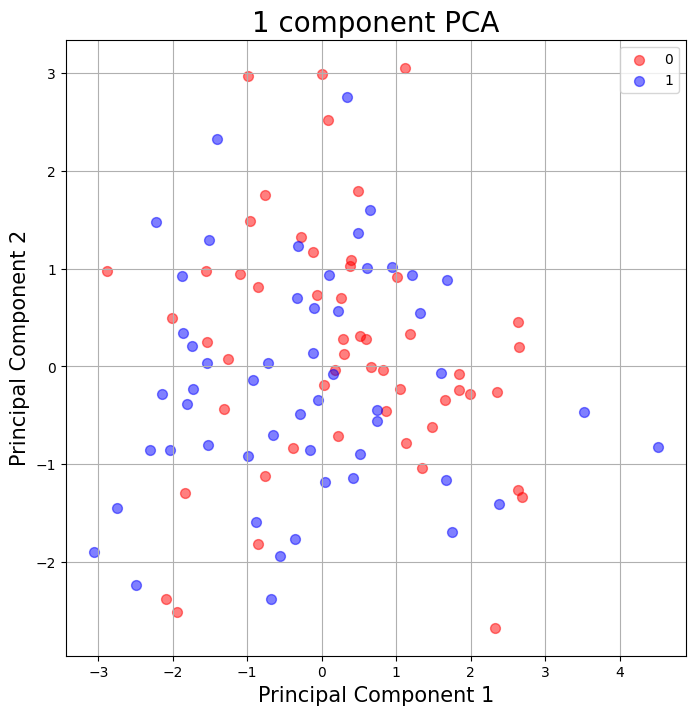

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('1 component PCA', fontsize=20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = VarRatioDF['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50, alpha=0.5)
ax.legend(targets)
ax.grid()

In [ ]:
pd.concat([principalDf.loc[:, 'principal component1'], principalDf.loc[:, 'principal component2'], labelDF], axis=1)

,principal component1,principal component2,0
0,2.691097,-1.335786,0
1,1.015661,0.917819,0
2,1.188745,0.334527,0
3,2.654164,0.202501,0
4,0.185358,-0.034405,0
...,...,...,...
101,-2.311559,-0.849867,1
102,-0.992652,-0.918731,1
103,0.155075,-0.081466,1
104,-1.517426,1.292567,1
